In [85]:
!pip install google-play-scraper pandas
!pip install pandas Sastrawi
!pip install transformers torch scipy



In [59]:
from google_play_scraper import reviews, Sort
import pandas as pd
import time
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Prepossesing & Data claeaning

In [88]:
# Baca data hasil scraping
url = 'https://drive.google.com/uc?id=1kN0jnSMo2CvTO_U0uxDCAbbdTrROJ19Z'
df = pd.read_csv(url)

# Hapus baris kosong
df.dropna(subset=['content'], inplace=True)

# Inisialisasi stemmer Bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi untuk membersihkan teks
def clean_text(text):
    text = str(text)
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # hapus URL
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # hapus angka & tanda baca
    text = re.sub(r'\s+', ' ', text).strip()  # hapus spasi berlebih
    text = stemmer.stem(text)  # stemming Bahasa Indonesia
    return text

# Terapkan
df['clean_text'] = df['content'].apply(clean_text)

# Simpan hasil preprocessing
df.to_csv('spotify_reviews_clean.csv', index=False)
print(" Preprocessing selesai! File tersimpan ke spotify_reviews_clean.csv")

 Preprocessing selesai! File tersimpan ke spotify_reviews_clean.csv


Data Labeling

In [37]:
import pandas as pd

# Baca file CSV hasil scraping atau cleaning
df = pd.read_csv('spotify_reviews_clean.csv')

# Cek dulu kolomnya
print("Kolom yang ada di dataset:", df.columns.tolist())

# Buat kamus kata positif dan negatif sederhana
lexicon_pos = ["bagus", "hebat", "keren", "senang", "puas", "baik", "mantap", "top","favorit","good","baru","love","nyaman","suka","seru",""]
lexicon_neg = ["buruk", "jelek", "kecewa", "marah", "sedih", "tidak puas", "error", "lemot","menganggu","anjing","anj","ngebug","bug","iklan","susah","ngelunjak","jangan","error","ga enak","boikot","ngebug","iklan"]

# Fungsi deteksi sentimen sederhana
def lexicon_sentiment(text):
    if not isinstance(text, str):
        return "neutral"
    text = text.lower()
    pos_count = sum(1 for w in lexicon_pos if w in text)
    neg_count = sum(1 for w in lexicon_neg if w in text)
    if pos_count > neg_count:
        return "positive"
    elif neg_count > pos_count:
        return "negative"
    else:
        return "neutral"

# Terapkan ke kolom teks ulasan
df['sentiment'] = df['content'].apply(lexicon_sentiment)  # ganti 'content' sesuai kolom teks kamu

# Lihat hasil
print(df[['content', 'sentiment']].head())

#  Lihat jumlah tiap label
print("\nDistribusi sentimen:")
print(df['sentiment'].value_counts())

# Simpan hasil akhir
df.to_csv('spotify_sentiment_labeled.csv', index=False)
print("\n✅ Hasil disimpan ke spotify_sentiment_labeled.csv")


Kolom yang ada di dataset: ['userName', 'content', 'at', 'clean_text']
                                             content sentiment
0  setiap baru play' satu musik langsung dikasih ...   neutral
1                      suka banget sama aplikasi ini  positive
2                                  my favorit person  positive
3                                          kerennnnn  positive
4                                              bguss  positive

Distribusi sentimen:
sentiment
positive    16667
negative     2026
neutral      1307
Name: count, dtype: int64

✅ Hasil disimpan ke spotify_sentiment_labeled.csv


Distribusi Data

sentiment
positive    16667
negative     2026
neutral      1307
Name: count, dtype: int64


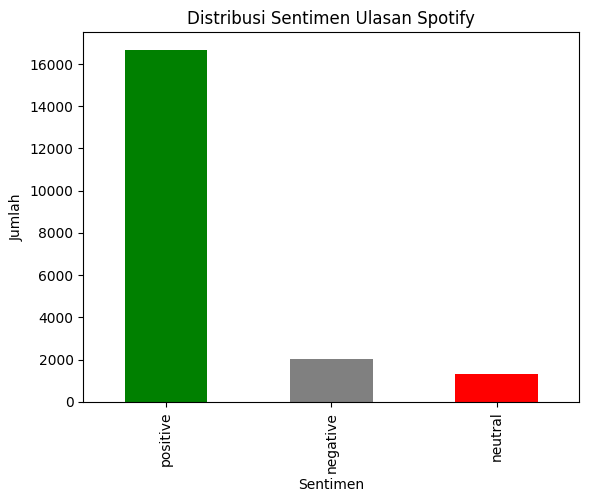


Contoh ulasan NEUTRAL:
["setiap baru play' satu musik langsung dikasih iklan 2 ,itu sangat menggangu", 'anjj', 'bagus tapi banyak iklan yang ganggu']

Contoh ulasan POSITIVE:
['suka banget sama aplikasi ini', 'my favorit person', 'kerennnnn']

Contoh ulasan NEGATIVE:
['Aplikasi nya sering ngebug mencet lagu malah gk ke play harus dibuka ulang tolong diperbaiki dan paketnya dimurahkan', 'telamapau bayak iklan', 'aplikasi nggak guna,,mending download lagu lewat google, gak ada iklan, ini tiap 2 lagu iklan, emang gw denger lagu atau iklan nihh!!!']


In [38]:
# Cek distribusi label
print(df['sentiment'].value_counts())

# Visualisasi
import matplotlib.pyplot as plt
df['sentiment'].value_counts().plot(kind='bar', color=['green','gray','red'])
plt.title('Distribusi Sentimen Ulasan Spotify')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

# Cek contoh per kelas
for label in df['sentiment'].unique():
    print(f"\nContoh ulasan {label.upper()}:")
    print(df[df['sentiment'] == label]['content'].head(3).to_list())


Data Load hasil lebeling

In [79]:
# --- 2. Load data ---
df = pd.read_csv('spotify_sentiment_labeled.csv')
df = df[['clean_text', 'sentiment']].dropna()

print("Jumlah data:", len(df))
print(df['sentiment'].value_counts())

# Ekstraksi fitur TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_text'])
y = df['sentiment']


Jumlah data: 19581
sentiment
positive    16248
negative     2026
neutral      1307
Name: count, dtype: int64


SVM + TF IDF

In [80]:

# Split data 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Evaluasi
y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

print("=== HASIL: SVM + TF-IDF (80/20) ===")
print(f"Akurasi Training: {accuracy_score(y_train, y_pred_train)*100:.2f}%")
print(f"Akurasi Testing : {accuracy_score(y_test, y_pred_test)*100:.2f}%\n")
print(classification_report(y_test, y_pred_test))

=== HASIL: SVM + TF-IDF (80/20) ===
Akurasi Training: 97.58%
Akurasi Testing : 95.05%

              precision    recall  f1-score   support

    negative       0.89      0.84      0.87       405
     neutral       0.74      0.56      0.64       262
    positive       0.97      1.00      0.98      3250

    accuracy                           0.95      3917
   macro avg       0.87      0.80      0.83      3917
weighted avg       0.95      0.95      0.95      3917



RANDOM FOREST + TF IDF

In [81]:
# Random Forest dengan TF-IDF
# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42
)

# Latih Model
rf_model.fit(X_train, y_train)

#Prediksi dan Evaluasi
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

print("=== HASIL: Random Forest + TF-IDF (80/20) ===")
print(f"Akurasi Training: {accuracy_score(y_train, y_pred_train)*100:.2f}%")
print(f"Akurasi Testing : {accuracy_score(y_test, y_pred_test)*100:.2f}%\n")
print(classification_report(y_test, y_pred_test))

=== HASIL: Random Forest + TF-IDF (80/20) ===
Akurasi Training: 90.25%
Akurasi Testing : 87.72%

              precision    recall  f1-score   support

    negative       0.85      0.43      0.57       405
     neutral       0.88      0.05      0.10       262
    positive       0.88      1.00      0.94      3250

    accuracy                           0.88      3917
   macro avg       0.87      0.49      0.54      3917
weighted avg       0.88      0.88      0.84      3917



LOGISTIC REGRESSION + TF IDF

In [82]:

# Split data 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Model Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Evaluasi model
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

print("=== HASIL: Logistic Regression + TF-IDF (70/30) ===")
print(f"Akurasi Training: {accuracy_score(y_train, y_pred_train)*100:.2f}%")
print(f"Akurasi Testing : {accuracy_score(y_test, y_pred_test)*100:.2f}%\n")
print(classification_report(y_test, y_pred_test))

=== HASIL: Logistic Regression + TF-IDF (70/30) ===
Akurasi Training: 95.71%
Akurasi Testing : 93.43%

              precision    recall  f1-score   support

    negative       0.87      0.82      0.84       608
     neutral       0.74      0.35      0.48       392
    positive       0.95      1.00      0.97      4875

    accuracy                           0.93      5875
   macro avg       0.85      0.72      0.76      5875
weighted avg       0.93      0.93      0.93      5875



In [78]:
#Perbandingan Model
summary = pd.DataFrame({
    'Model': ['SVM', 'Random Forest', 'Logistic Regression'],
    'Ekstraksi Fitur': ['TF-IDF', 'TF-IDF', 'TF-IDF'],
    'Split Data': ['80/20', '80/20', '70/30'],
    'Akurasi Training (%)': [acc1_train, acc2_train, acc3_train],
    'Akurasi Testing (%)': [acc1_test, acc2_test, acc3_test]
})

print("\n=== PERBANDINGAN TIGA MODEL ===")
print(summary.to_string(index=False))



=== PERBANDINGAN TIGA MODEL ===
              Model Ekstraksi Fitur Split Data  Akurasi Training (%)  Akurasi Testing (%)
                SVM          TF-IDF      80/20             97.580439            95.047230
      Random Forest          TF-IDF      80/20             91.579418            88.792443
Logistic Regression          TF-IDF      70/30             95.709908            93.429787


In [86]:
!pip freeze > requirements.txt